In [39]:
import torch
import torch.nn as nn
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

reference: https://pytorch-geometric.readthedocs.io/en/latest/tutorial/heterogeneous.html

### Creating Heterogeneous Graph

In [32]:
data = HeteroData()

num_users = 10
num_items = 100
num_features_user = 5
num_features_item = 7
num_transactions = 100
num_features_transaction = 3

data['user'].x = torch.rand((num_users, num_features_user))
data['item'].x = torch.rand((num_items, num_features_item))

data['user', 'buys', 'item'].edge_index = torch.stack([
    torch.randint(high=num_users, size=(num_transactions,)),
    torch.randint(high=num_items, size=(num_transactions,))
])

data['user', 'buys', 'item'].edge_attr = torch.rand((num_transactions, num_features_transaction))
data['user', 'buys', 'item'].y = torch.randint(low=1, high=6, size=(num_transactions,)).to(torch.float)

data = T.ToUndirected()(data)

print(data)

HeteroData(
  user={ x=[10, 5] },
  item={ x=[100, 7] },
  (user, buys, item)={
    edge_index=[2, 100],
    edge_attr=[100, 3],
    y=[100]
  },
  (item, rev_buys, user)={
    edge_index=[2, 100],
    edge_attr=[100, 3],
    y=[100]
  }
)


### Data Splitting

In [62]:
import random
from torch_geometric.utils import index_to_mask

def edge_splitting(data: HeteroData, split_ratio=[0.7, 0.2, 0.1]) -> HeteroData:
    edge_num = data['user', 'buys', 'item'].edge_index.shape[1]
    edge_idxs = list(range(edge_num))
    random.shuffle(edge_idxs)

    # split edge index
    train_ratio, valid_ratio, test_ratio = split_ratio
    assert abs(train_ratio + valid_ratio + test_ratio - 1.0) < 1e-3, "The sum ratio of train/valid/test should be 1!"
    train_num = int(edge_num * train_ratio)
    valid_num = int(edge_num * valid_ratio)
    test_num = edge_num - train_num - valid_num
    train_index = torch.tensor(edge_idxs[:train_num])
    valid_index = torch.tensor(edge_idxs[train_num:-test_num])
    test_index = torch.tensor(edge_idxs[-test_num:])

    # convert index to mask
    train_mask = index_to_mask(train_index, size=edge_num)
    valid_mask = index_to_mask(valid_index, size=edge_num)
    test_mask = index_to_mask(test_index, size=edge_num)
    assert torch.all((train_mask + valid_mask + test_mask + 0) == torch.ones(edge_num))
    data['user', 'buys', 'item'].train_mask = train_mask
    data['user', 'buys', 'item'].valid_mask = valid_mask
    data['user', 'buys', 'item'].test_mask = test_mask

    return data


In [64]:
data = edge_splitting(data, [0.7, 0.2, 0.1])
print(data)

HeteroData(
  user={ x=[10, 5] },
  item={ x=[100, 7] },
  (user, buys, item)={
    edge_index=[2, 100],
    edge_attr=[100, 3],
    y=[100],
    train_mask=[100],
    valid_mask=[100],
    test_mask=[100]
  },
  (item, rev_buys, user)={
    edge_index=[2, 100],
    edge_attr=[100, 3],
    y=[100]
  }
)


### Creating Heterogeneous GNNs
PyG provides three ways to create models on heterogenrous graph data:
1. `torch_geometric.nn.to_hetero()` to convert model
2. `conv.HeteroConv` to define individual functions for different types
3. Deploy existing heterogeneous GNN operators

For me, the second one is more clear and easy to understand, so I will use it in the following exampe.

In [30]:
from torch_geometric.nn import HeteroConv, SAGEConv, GATv2Conv

class HeteroGNN(torch.nn.Module):
    def __init__(self, user_dim, item_dim, transaction_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        
        self.lin_proj_user = nn.Linear(user_dim, hidden_dim)
        self.lin_proj_item = nn.Linear(item_dim, hidden_dim)
        
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('user', 'buys', 'item'): GATv2Conv((hidden_dim, hidden_dim), hidden_dim, heads=2, edge_dim=transaction_dim, concat=False, add_self_loops=False),
                ('item', 'rev_buys', 'user'): GATv2Conv((hidden_dim, hidden_dim), hidden_dim, heads=2, edge_dim=transaction_dim, concat=False, add_self_loops=False)
            })
            self.convs.append(conv)
        
        self.edge_embedding_mlp = torch.nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # linear projections
        for node_type, x in x_dict.items():
            if node_type == 'user':
                x_dict[node_type] = self.lin_proj_user(x)
            elif node_type == 'item':
                x_dict[node_type] = self.lin_proj_item(x)
        
        # message passing convolutions
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict, **{'edge_attr_dict': edge_attr_dict})
            x_dict = {node_type: x.relu() for node_type, x in x_dict.items()}
        
        # edge embedding calculation
        index_i, index_j = edge_index_dict[('user', 'buys', 'item')]
        user_embedding_i = x_dict['user'][index_i]
        item_embedding_j = x_dict['item'][index_j]
        edge_embedding = torch.cat([user_embedding_i, item_embedding_j], dim=1)
        edge_output = self.edge_embedding_mlp(edge_embedding).squeeze()

        return edge_output


model_kwargs = {
    'user_dim': num_features_user,
    'item_dim': num_features_item,
    'transaction_dim': num_features_transaction,
    'hidden_dim': 64,
    'output_dim': 1,
    'num_layers': 1
}
model = HeteroGNN(**model_kwargs)
print(model)

HeteroGNN(
  (lin_proj_user): Linear(in_features=5, out_features=64, bias=True)
  (lin_proj_item): Linear(in_features=7, out_features=64, bias=True)
  (convs): ModuleList(
    (0): HeteroConv(num_relations=2)
  )
  (edge_embedding_mlp): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


### Train the GNN model

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()

In [33]:
def train():
    model.train()
    edge_prediction = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
    loss = criterion(edge_prediction, data['user', 'buys', 'item'].y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

In [34]:
loss_record = []
for _ in range(50):
    loss = train()
    print("loss:", loss)
    loss_record.append(loss)

loss: 9.126710891723633
loss: 7.795230865478516
loss: 6.110370635986328
loss: 3.770066499710083
loss: 1.7855193614959717
loss: 3.4953787326812744
loss: 3.292215347290039
loss: 2.011885404586792
loss: 1.671393871307373
loss: 1.9974029064178467
loss: 2.3623452186584473
loss: 2.5033180713653564
loss: 2.396092176437378
loss: 2.1078011989593506
loss: 1.7762435674667358
loss: 1.601033329963684
loss: 1.7315542697906494
loss: 1.9990075826644897
loss: 1.9539086818695068
loss: 1.7545526027679443
loss: 1.596360683441162
loss: 1.5832632780075073
loss: 1.6580525636672974
loss: 1.726332426071167
loss: 1.7318392992019653
loss: 1.673172950744629
loss: 1.590930461883545
loss: 1.5456945896148682
loss: 1.5712056159973145
loss: 1.6160377264022827
loss: 1.6124310493469238
loss: 1.5657296180725098
loss: 1.5256266593933105
loss: 1.5210720300674438
loss: 1.5403436422348022
loss: 1.5544131994247437
loss: 1.5461535453796387
loss: 1.5203940868377686
loss: 1.4970866441726685
loss: 1.4927401542663574
loss: 1.50337

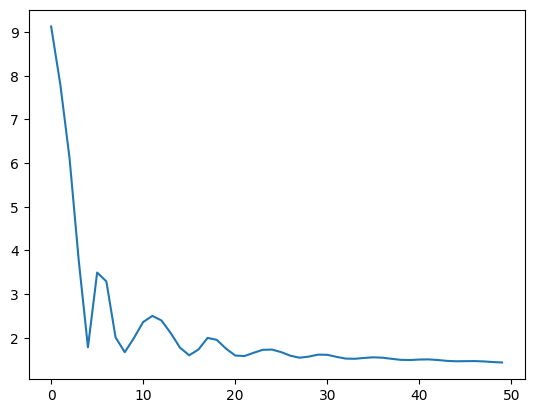

In [36]:
import matplotlib.pyplot as plt

plt.plot(loss_record)
plt.show()